# Using abundances 

In [206]:
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
%matplotlib inline

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 30,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Define the function I need for the linear regression.

In [207]:
def train(y, X):
    """
    
    Args:
        y (array): An Nstar array of ages.
        X (array): An Nstar x NX array of abundances.
        
    Returns:
        weights (array): The array of weights of length NX + 1.
        
    """
    
    A = np.concatenate((np.ones((len(X), 1)), X), axis=1)
    AT = A.T
    ATA = np.dot(AT, A)
    weights = np.linalg.solve(ATA, np.dot(AT, y))
    return weights

In [208]:
t = Table.read("APOKASC_cat_v4.5.1_KITP.fits")
df = t.to_pandas()
df.head()

,KEPLER_ID,KEPLER_INT,2MASS_ID,LOC_ID,RA,DEC,GAIA_PARALLAX_DR2,GAIA_PARALLAX_DR2_ERR,GAIA_MAG,GAIA_BP_MAG,...,APOKASC2_AGE,APOKASC2_AGE_PERR,APOKASC2_AGE_MERR,APOKASC2_AV,APOKASC2_AV_ERR,GAIA_TEFF,GAIA_RADIUS,GAIA_LUMINOSITY,CONS_EVSTATES,EB_PER
0,b'10000151',10000151,b'2M19051857+4654038',b'5006',286.327395,46.901066,0.498482,0.015962,14.050219,14.589542,...,-9999.000000,-9999.000000,-9999.000000,-9999.000,-9999.000,4915.970215,3.920701,8.088337,b'-9999',-9999.000000
1,b'10000198',10000198,b'2M19052775+4658526',b'5006',286.365656,46.981289,0.400787,0.013683,13.774379,14.319761,...,-9999.000000,-9999.000000,-9999.000000,-9999.000,-9999.000,4955.666504,5.423189,15.981311,b'-9999',-9999.000000
2,b'10000207',10000207,b'2M19052985+4654372',b'4405',286.374415,46.910336,0.778100,0.021504,12.416382,12.978867,...,8.413952,1.291148,1.085706,0.053,0.075,4905.266602,5.360471,14.988256,b'RGB',-9999.000000
3,b'10000547',10000547,b'2M19062193+4657016',b'4405',286.591376,46.950447,0.928903,0.021694,12.181162,12.684856,...,5.902011,1.016299,0.820416,0.090,0.079,4952.459961,4.881617,12.915346,b'RGB',-9999.000000
4,b'10001167',10001167,b'2M19074937+4656118',b'4405',286.955745,46.936623,1.227024,0.026743,10.039207,10.616713,...,9.616123,1.348659,1.163334,0.000,0.070,4649.456543,11.732424,57.953407,b'RGB',120.390968


Mask bad values.

In [209]:
mask = df["APOKASC2_AGE"].values != -9999.00
mask &= df["FE_H_ADOP_COR"].values != -9999.00
mask &= df["AL_FE"].values != -9999.00
mask &= df["CA_FE"].values != -9999.00
mask &= df["MG_FE"].values != -9999.00
mask &= df["MN_FE"].values != -9999.00
mask &= df["O_FE"].values != -9999.00 # 
mask &= df["SI_FE"].values != -9999.00
mask &= df["S_FE"].values != -9999.00
mask &= df["V_FE"].values != -9999.00

In [210]:
d = df.iloc[mask]
feh, alfe, cafe, mgfe, mnfe, ofe = d.FE_H_ADOP_COR, d.AL_FE, d.CA_FE, d.MG_FE, d.MN_FE, d.O_FE
sife, sfe, vfe = d.SI_FE, d.S_FE, d.V_FE

In [211]:
X = np.vstack((feh, alfe, cafe, mgfe, mnfe, ofe, sife, sfe, vfe,
               feh**2, alfe**2, cafe**2, mgfe**2, mnfe**2, ofe**2, sife**2, sfe**2, vfe**2
              )).T
print(np.shape(X))
y = d[['APOKASC2_AGE']].values

(6322, 18)


In [212]:
from itertools import combinations_with_replacement

args = feh, alfe, cafe, mgfe, mnfe, ofe, sife, sfe, vfe
X = list(args)
for a, b in combinations_with_replacement(args, 2):
    X.append(a * b)
X = np.array(X).T
print(np.shape(X))

(6322, 54)


Shuffle X and y

In [243]:
# Define the number of training and validating stars.
Ntrain = 10000
Ntest = len(y) - Ntrain

# Choose stars at random and split.
shuffle_inds = np.arange(len(y))

train_inds = shuffle_inds[:Ntrain]
test_inds = shuffle_inds[Ntrain:]
y_train = y[train_inds]
X_train = X[train_inds, :]
y_test = y[test_inds]
X_test = X[test_inds, :]
print(np.shape(y_train), np.shape(y_test))

TypeError: 'NoneType' object is not subscriptable

In [239]:
weights = train(y_train, X_train)

In [240]:
A = np.concatenate((np.ones((len(X_train), 1)), X_train), axis=1)
y_predict = np.dot(weights.T, A.T)

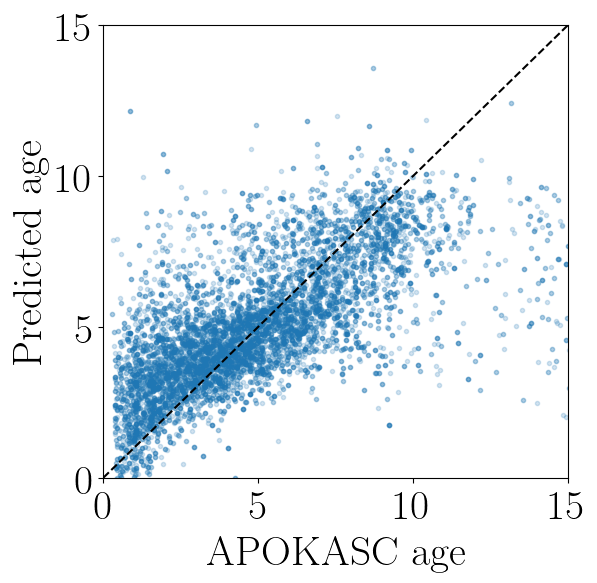

In [241]:
xs = np.linspace(0, 15, 100)

plt.figure(figsize=(6, 6), dpi=100)
plt.plot(y_train, y_predict.T, ".", alpha=.2)
plt.plot(xs, xs, "k--")
plt.xlim(0, 15)
plt.ylim(0, 15)
plt.xlabel("$\mathrm{APOKASC~age}$")
plt.ylabel("$\mathrm{Predicted~age}$")
plt.savefig("abundance_ages.pdf")

In [229]:
print(np.sqrt(np.sum((y_train - y_predict.T)**2)))

238.289942996515


In [234]:
A_test = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
y_predict_test = np.dot(weights.T, A_test.T)

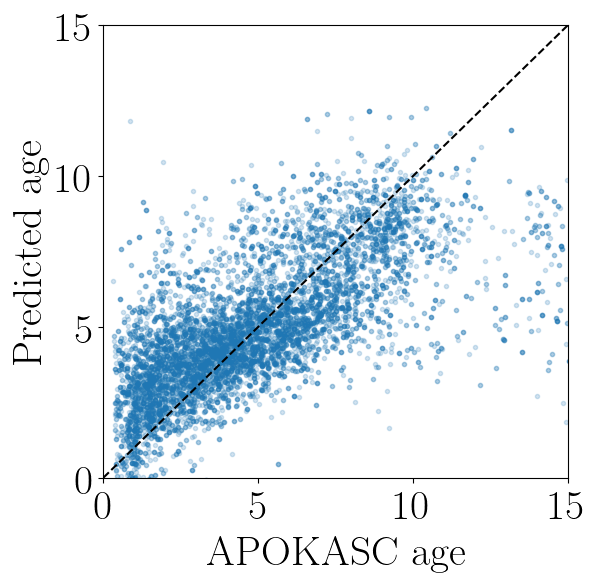

In [235]:
xs = np.linspace(0, 15, 100)

plt.figure(figsize=(6, 6), dpi=100)
plt.plot(y_test, y_predict_test.T, ".", alpha=.2)
plt.plot(xs, xs, "k--")
plt.xlim(0, 15)
plt.ylim(0, 15)
plt.xlabel("$\mathrm{APOKASC~age}$")
plt.ylabel("$\mathrm{Predicted~age}$")
plt.savefig("abundance_ages.pdf")